In [65]:
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import matplotlib.pyplot as plt

We can starting with the simplest example: y = x^2, where X is a 1 column matrix, and Y is the square of X.  In this case, the importance curve should be exactly the same as the tree's prediction curve.

In [66]:
#generating data
X = np.random.uniform(0, 10, (1000, 1))
Y = X ** 2
labels = ['X']

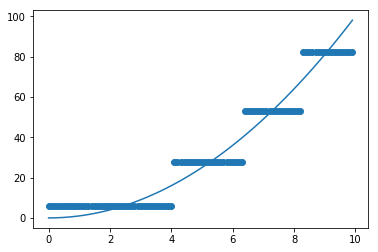

In [68]:
#generating the prediction curve, where tree depth is limited to 2
model = DecisionTreeRegressor(max_depth=2)
model.fit(X, Y)
test_X = np.reshape(np.arange(0, 10, .1), (-1, 1))
true_Y = test_X ** 2
preds = model.predict(test_X)
plt.scatter(test_X, preds)
plt.plot(test_X, true_Y)
#tree predictions plotted vs input, y=x**2 added for reference

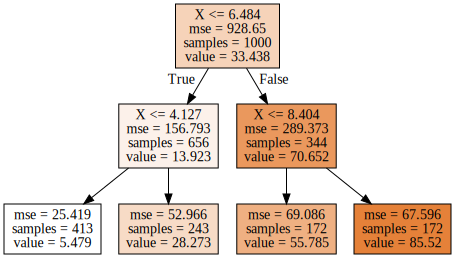

In [52]:
#visualizing the tree
graph = Source(tree.export_graphviz(model, out_file=None
   , feature_names=labels, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))


In [32]:
#Helper function for path traversal/analysis
#X, Y are datasets, where rows in X correspond to features, and Y is 1 column of outcomes
#threshold, feature, and direction describe a decision rule:
#e.g. for x_0>= 1.5 threshold = 1.5, feature = 0, direction = 'geq'
#this function applies a the rule to the X dataset, and then applies that selection to the Y dataset as well
def apply_rule(X, Y, threshold, feature, direction):
    mask = []
    if(direction == "geq"):
        mask = X[:, feature] >= threshold
    else:
        mask = X[:, feature] < threshold
    new_X = X[mask]
    new_Y = Y[mask]
    return (new_X, new_Y)

In [33]:
#The purpose of this function is to traverse each path from root to leaf in a tree
#each leaf node will be associated with an set of intervals, one interval per feature specified in S, a value, and a count
#of training points that fall into said intervals.
def traverse_all_paths(model, input_space_x, outcome_space_y, S, continuous_y = False):
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    datasets = {}
    num_feats = len(S)#np.count_nonzero(S)
    datasets[0] = (input_space_x, outcome_space_y)
    intervals = {}
    intervals[0] =[(- float('inf'), float('inf'))] * num_feats
    leaves = []
    fringe = [0]
    while len(fringe) > 0:
        curr_node = fringe.pop()
        #print("curr_node", curr_node)
        bound = threshold[curr_node]
        feat = feature[curr_node]
        #print("bound", bound, "on feature", feat)
        child_left = children_left[curr_node]
        child_right = children_right[curr_node]
        #print("children (left, right)", child_left, child_right)
        if (child_left != child_right):
            #print("non-leaf")
            X, Y = datasets[curr_node]
            #print("current node data set X\n", X)
            #print("current node data set Y\n", Y)
            left_data = (X, Y)
            right_data = (X, Y)
            left_interval = intervals[curr_node]
            right_interval = intervals[curr_node]
            #print("current node interval", intervals[curr_node])
            if(S[feat] == 1):
                left_data = apply_rule(X, Y, bound, feat, "less")
                #print("left data", left_data)
                right_data = apply_rule(X, Y, bound, feat, "geq")
                #print("right data", right_data)

                left_interval = intervals[curr_node][0:feat] + [(intervals[curr_node][feat][0], bound)] + intervals[curr_node][feat + 1:len(intervals[curr_node])]
                #print("left interval", left_interval)
                right_interval = intervals[curr_node][0:feat] + [(bound, intervals[curr_node][feat][1])] + intervals[curr_node][feat + 1:len(intervals[curr_node])]
                #print("right interval", right_interval)
            datasets[child_left] = left_data
            datasets[child_right] = right_data
            intervals[child_left] = left_interval
            intervals[child_right] = right_interval
            fringe.append(child_left)
            fringe.append(child_right)
        else:
            #print("leaf")
            leaves.append(curr_node)
    values = []
    #print("leaves", leaves)
    if(continuous_y):
        for leaf in leaves:
            X, Y = datasets[leaf]
            inter = intervals[leaf]
            average = np.average(Y)
            values.append(inter + [average] + [len(Y)])
        return values
    for leaf in leaves:
        X, Y = datasets[leaf]
        inter = intervals[leaf]
        proportion = np.count_nonzero(Y == 1)/Y.shape[0]
        values.append(inter + [proportion] + [len(Y)])
    return values

In [34]:
#This function's purpose is to take the output of traverse_all_paths, and turn it into a set of sequential values
#over an interval that can be graphed
def make_line(values, interval_x, di, ind, num_vars):
    xdim = (int)((interval_x[1] - interval_x[0])/di)
    x_axis = np.arange(interval_x[0], interval_x[1], di)
    line = np.zeros(x_axis.shape)
    counts = np.zeros(x_axis.shape)
    for i in range(xdim):
        x_coord = x_axis[i]
        for v in values:
            x_inter = v[0:num_vars][ind]
            val, count = v[num_vars:]
            if x_coord>=x_inter[0] and x_coord < x_inter[1]:
                line[i] += count * val
                counts[i] += count
    return line/counts

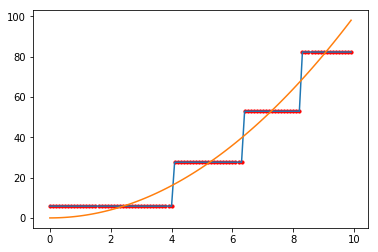

In [70]:
#testing the above functions on the previously described data
vals = traverse_all_paths(model, X, Y, [1], continuous_y = True)
scores = make_line(vals, (0, 10), .1, 0, 1)
x_axis = np.arange(0, 10, .1)
plt.plot(x_axis, scores)
plt.scatter(test_X, preds, c='r', s=10)
plt.plot(test_X, true_Y)
plt.show()

In [71]:
#now let's split X into two columns, and have y = x_0 * x_1, where x_0 = x_1
X_0 = np.random.uniform(0, 10, (1000, 1))
X = np.hstack((X_0, X_0))
print(X.shape)
Y = X_0 **2
labels = ['x0', 'x1']

(1000, 2)


(100, 2)


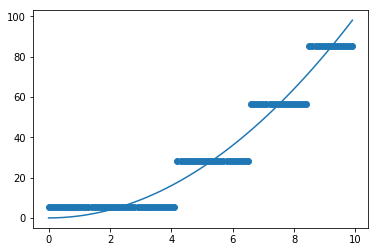

In [81]:
#plotting the tree outputs vs y=x^2
#this model should look very similar to the previous
model = DecisionTreeRegressor(max_depth=2)
model.fit(X, Y)
x_axis = np.arange(0, 10, .1)
test_X = np.transpose(np.vstack((x_axis, x_axis)))
print(test_X.shape)
preds = model.predict(test_X)
plt.scatter(x_axis, preds)
plt.plot(x_axis, true_Y)

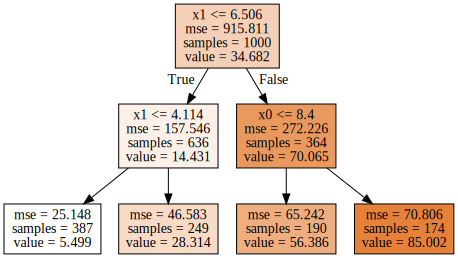

In [82]:
#visualizing the tree
graph = Source(tree.export_graphviz(model, out_file=None
   , feature_names=labels, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

[[(8.400497436523438, inf), (-inf, inf), 85.0016565236557, 174], [(-inf, 8.400497436523438), (-inf, inf), 24.081833034829376, 826], [(-inf, inf), (-inf, inf), 34.68188232188516, 1000], [(-inf, inf), (-inf, inf), 34.68188232188516, 1000]]


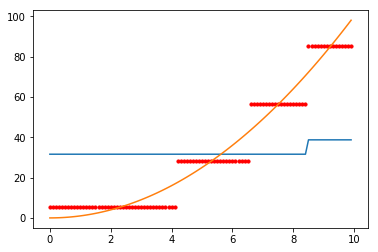

In [83]:
#testing the methods with this new data
#hopefully the importance curve will approach the x**2 curve
vals = traverse_all_paths(model, X, Y, [1, 0], continuous_y = True)
print(vals)
scores = make_line(vals, (0, 10), .1, 0, 2)
x_axis = np.arange(0, 10, .1)
plt.plot(x_axis, scores)
plt.scatter(x_axis, preds, c='r', s=10)
plt.plot(x_axis, true_Y)
plt.show()